In [56]:
# Cell 1:
import pandas as pd
import json
import os
import ast # For safely evaluating string representations of lists
import matplotlib.pyplot as plt
import numpy as np
import re # For extracting threshold from folder name
from pathlib import Path
import matplotlib.ticker as mticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # Use tab10 color palette

# --- Configuration ---
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path("/home/users/ntu/{user}/slimsc/prune/results".format(user=user))
GPQA_BASE_PATH = Path(f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/gpqa_diamond/")
AIME_BASE_PATH = Path(f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/aime/")

# Define the experiment sets (assumed to be the same for GPQA and AIME)
EXPERIMENT_SUBFOLDERS = [
    "diversity_n64_thresh0.92_delay20",
    "diversity_n64_thresh0.95_delay20",
    "diversity_n64_thresh0.98_delay20",
    "random_n64_thresh0.92_delay20",
    "random_n64_thresh0.95_delay20",
    "random_n64_thresh0.98_delay20",
]

# Baselines subfolders, expected to exist under both GPQA_BASE_PATH and AIME_BASE_PATH
BASELINE_SUBFOLDERS = [
    # "sc_1_control",
    # "sc_64_control"
]

# For parsing strategy and threshold
def parse_experiment_name(folder_name):
    strategy_match = re.search(r"^(diversity|random)_", folder_name)
    threshold_match = re.search(r"thresh(\d+\.\d+)", folder_name)
    
    strategy = strategy_match.group(1) if strategy_match else None
    threshold = float(threshold_match.group(1)) if threshold_match else None
    
    return strategy, threshold

# Function to check if correct answer is in candidates
def check_correct_in_candidates(row):
    try:
        # Ensure 'individual_answers_str' exists and is a string
        if 'individual_answers_str' not in row or not isinstance(row['individual_answers_str'], str):
            return False
        # Ensure 'correct_answer' is not NaN or None before converting to string
        if pd.isna(row['correct_answer']):
            return False
            
        candidates = ast.literal_eval(row['individual_answers_str'])
        # MODIFICATION: Convert correct_answer to string for comparison
        return str(row['correct_answer']) in candidates
    except (ValueError, SyntaxError, KeyError): # Handle malformed strings, empty lists, or missing keys
        return False

In [57]:
# Cell 2:
def load_experiment_metrics(base_path, exp_subfolder):
    """
    Loads metrics from a single experiment's evaluation_summary.csv and aggregated_metrics.json.
    Converts accuracy and pct_correct_in_candidates to percentages (0-100).
    Ensures other numeric metrics are converted to float.
    """
    full_path = os.path.join(base_path, exp_subfolder)
    eval_summary_path = os.path.join(full_path, "evaluation_summary.csv")
    agg_metrics_path = os.path.join(full_path, "aggregated_metrics.json")

    metrics = {
        "folder": exp_subfolder,
        "accuracy": None,
        "pct_correct_in_candidates": None,
        "mean_completion_tokens": None,
        "mean_processing_time": None,
        "strategy": None,
        "threshold": None
    }

    def to_float_or_none(val, field_name_for_warning="value"):
        if val is None:
            return None
        try:
            if isinstance(val, str):
                cleaned_val_str = re.sub(r"[^0-9.]", "", val)
                if not cleaned_val_str:
                    return None
                return float(cleaned_val_str)
            return float(val)
        except (ValueError, TypeError):
            print(f"Warning: Could not convert {field_name_for_warning} '{val}' from {exp_subfolder} (path: {base_path}) to float. Setting to None.")
            return None

    if os.path.exists(eval_summary_path):
        try:
            df_eval = pd.read_csv(eval_summary_path)
            if not df_eval.empty and 'final_score' in df_eval.columns:
                df_eval['final_score'] = pd.to_numeric(df_eval['final_score'], errors='coerce')
                accuracy_val = to_float_or_none(df_eval['final_score'].mean(), "accuracy from eval_summary")
                if accuracy_val is not None:
                    metrics["accuracy"] = accuracy_val * 100 # Convert to percentage
                
                if 'individual_answers_str' in df_eval.columns and 'correct_answer' in df_eval.columns:
                    df_eval['correct_in_candidates'] = df_eval.apply(check_correct_in_candidates, axis=1)
                    pct_val = to_float_or_none(df_eval['correct_in_candidates'].mean(), "pct_correct_in_candidates from eval_summary")
                    if pct_val is not None:
                        metrics["pct_correct_in_candidates"] = pct_val * 100 # Convert to percentage
                else:
                    print(f"Warning: 'individual_answers_str' or 'correct_answer' column missing in {eval_summary_path}. Cannot calculate pct_correct_in_candidates.")
            elif df_eval.empty:
                print(f"Warning: {eval_summary_path} is empty.")
            else:
                print(f"Warning: 'final_score' column missing in {eval_summary_path}.")
        except Exception as e:
            print(f"Error reading or processing {eval_summary_path}: {e}")
    else:
        print(f"Warning: {eval_summary_path} not found.")

    if os.path.exists(agg_metrics_path):
        try:
            with open(agg_metrics_path, 'r') as f:
                agg_data = json.load(f)
            json_metrics_dict = agg_data.get("metrics", {})
            
            mean_tokens_val = to_float_or_none(
                json_metrics_dict.get("mean_total_completion_tokens_per_question"),
                "mean_total_completion_tokens_per_question"
            )
            if mean_tokens_val is not None:
                 metrics["mean_completion_tokens"] = mean_tokens_val / 1000 # Convert to thousands

            metrics["mean_processing_time"] = to_float_or_none(
                json_metrics_dict.get("mean_processing_duration_sec_per_question"),
                "mean_processing_duration_sec_per_question"
            )
        except Exception as e:
            print(f"Error reading or processing {agg_metrics_path}: {e}")
    else:
        print(f"Warning: {agg_metrics_path} not found.")
        
    strategy, threshold_val = parse_experiment_name(exp_subfolder)
    if exp_subfolder not in BASELINE_SUBFOLDERS:
        metrics["strategy"] = strategy
        metrics["threshold"] = to_float_or_none(threshold_val, "threshold")
    else: 
        metrics["strategy"] = exp_subfolder 

    return metrics

In [58]:
# Cell 3:
# --- Load GPQA Pruning Experiments Data ---
gpqa_metrics_data = []
for subfolder in EXPERIMENT_SUBFOLDERS:
    metrics = load_experiment_metrics(GPQA_BASE_PATH, subfolder)
    if metrics["strategy"] and metrics["threshold"] is not None and metrics["strategy"] not in BASELINE_SUBFOLDERS:
        gpqa_metrics_data.append(metrics)
    elif metrics["strategy"] in BASELINE_SUBFOLDERS:
        pass 
    else:
        print(f"Could not parse strategy/threshold for GPQA {subfolder}, or it's a baseline. Skipping for main experiment list.")

df_gpqa_experiments = pd.DataFrame(gpqa_metrics_data)
for col in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time', 'threshold']:
    if col in df_gpqa_experiments.columns:
        df_gpqa_experiments[col] = pd.to_numeric(df_gpqa_experiments[col], errors='coerce')

print("--- GPQA Pruning Experiments Data ---")
if not df_gpqa_experiments.empty:
    print(df_gpqa_experiments.to_string())
else:
    print("No GPQA pruning experiment data loaded.")

# --- Load AIME Pruning Experiments Data ---
aime_metrics_data = []
for subfolder in EXPERIMENT_SUBFOLDERS:
    metrics = load_experiment_metrics(AIME_BASE_PATH, subfolder)
    if metrics["strategy"] and metrics["threshold"] is not None and metrics["strategy"] not in BASELINE_SUBFOLDERS:
        aime_metrics_data.append(metrics)
    elif metrics["strategy"] in BASELINE_SUBFOLDERS:
        pass
    else:
        print(f"Could not parse strategy/threshold for AIME {subfolder}, or it's a baseline. Skipping for main experiment list.")

df_aime_experiments = pd.DataFrame(aime_metrics_data)
if not df_aime_experiments.empty:
    for col in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time', 'threshold']:
        if col in df_aime_experiments.columns:
            df_aime_experiments[col] = pd.to_numeric(df_aime_experiments[col], errors='coerce')
    print("\n--- AIME Pruning Experiments Data ---")
    print(df_aime_experiments.to_string())
else:
    print("\nNo AIME pruning experiment data loaded.")

# --- Load GPQA Baseline Data ---
gpqa_baseline_metrics_data = {}
print("\n--- Loading GPQA Baselines ---")
for subfolder in BASELINE_SUBFOLDERS:
    metrics = load_experiment_metrics(GPQA_BASE_PATH, subfolder)
    gpqa_baseline_metrics_data[subfolder] = metrics
    # print(f"Loaded GPQA Baseline {subfolder}: Acc {metrics.get('accuracy')}")


print("\n--- GPQA Baseline Data ---")
for name, data in gpqa_baseline_metrics_data.items():
    print(f"{name}:")
    if data:
        acc = data.get('accuracy'); pct_cand = data.get('pct_correct_in_candidates')
        tokens = data.get('mean_completion_tokens'); time = data.get('mean_processing_time')
        print(f"  Accuracy: {acc:.2f}%" if acc is not None else "N/A")
        print(f"  % Correct in Candidates: {pct_cand:.2f}%" if pct_cand is not None else "N/A")
        print(f"  Mean Completion Tokens: {float(tokens):.2f}k" if tokens is not None else "N/A")
        print(f"  Mean Processing Time: {float(time):.2f}s" if time is not None else "N/A")
    else:
        print("  Data not loaded.")

# --- Load AIME Baseline Data ---
aime_baseline_metrics_data = {}
print("\n--- Loading AIME Baselines ---")
for subfolder in BASELINE_SUBFOLDERS:
    metrics = load_experiment_metrics(AIME_BASE_PATH, subfolder)
    aime_baseline_metrics_data[subfolder] = metrics
    # print(f"Loaded AIME Baseline {subfolder}: Acc {metrics.get('accuracy')}")


print("\n--- AIME Baseline Data ---")
for name, data in aime_baseline_metrics_data.items():
    print(f"{name}:")
    if data:
        acc = data.get('accuracy'); pct_cand = data.get('pct_correct_in_candidates')
        tokens = data.get('mean_completion_tokens'); time = data.get('mean_processing_time')
        print(f"  Accuracy: {acc:.2f}%" if acc is not None else "N/A")
        print(f"  % Correct in Candidates: {pct_cand:.2f}%" if pct_cand is not None else "N/A")
        print(f"  Mean Completion Tokens: {float(tokens):.2f}k" if tokens is not None else "N/A")
        print(f"  Mean Processing Time: {float(time):.2f}s" if time is not None else "N/A")
    else:
        print("  Data not loaded.")

--- GPQA Pruning Experiments Data ---
                             folder   accuracy  pct_correct_in_candidates  mean_completion_tokens  mean_processing_time   strategy  threshold
0  diversity_n64_thresh0.92_delay20  48.000000                  58.000000              188.707720            176.094023  diversity       0.92
1  diversity_n64_thresh0.95_delay20  62.121212                  71.717172              200.499101            199.059972  diversity       0.95
2  diversity_n64_thresh0.98_delay20  61.616162                  72.222222              235.143838            227.986663  diversity       0.98
3     random_n64_thresh0.92_delay20  61.111111                  70.202020              191.623313            184.958314     random       0.92
4     random_n64_thresh0.95_delay20  63.131313                  71.212121              198.144621            198.818318     random       0.95
5     random_n64_thresh0.98_delay20  65.151515                  72.222222              238.406045            2

In [79]:
# Cell 4:
# import matplotlib.ticker as mticker # Already imported in Cell 1

def plot_comparison(df_gpqa_exp, df_aime_exp, 
                    gpqa_baseline_data, aime_baseline_data, 
                    metric_key, y_label, lower_is_better=False):
    """
    Generates a line graph for a given metric, comparing GPQA and AIME strategies,
    with lines for GPQA and AIME baselines.
    AIME lines use the same color as GPQA but different texture (linestyle).
    Accuracy/Pct Correct in Candidates are plotted as percentages.
    No plot titles.
    Legend items are ordered specifically.
    """
    
    fig, ax = plt.subplots(figsize=(2.5, 2))

    strategy_colors = {
        'diversity': plt.cm.tab10.colors[0], 
        'random': plt.cm.tab10.colors[1]    
    }
    gpqa_linestyle = '-'
    gpqa_marker = 'o'
    aime_linestyle = '--'
    aime_marker = 'x'

    all_y_values_for_ylim = []
    
    all_thresholds_set = set()
    if df_gpqa_exp is not None and not df_gpqa_exp.empty and 'threshold' in df_gpqa_exp.columns:
        all_thresholds_set.update(df_gpqa_exp['threshold'].dropna().unique())
    if df_aime_exp is not None and not df_aime_exp.empty and 'threshold' in df_aime_exp.columns:
        all_thresholds_set.update(df_aime_exp['threshold'].dropna().unique())
    thresholds = sorted(list(all_thresholds_set))

    if not thresholds:
        print(f"No valid threshold data found for metric '{metric_key}'. Cannot plot lines.")
        ax.set_xlabel('Similarity Threshold', fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        # ax.legend(loc='best', fontsize=10) # Legend handled later
        ax.grid(True, linestyle='--', alpha=0.6, axis='y')
        fig.tight_layout()
        plt.show()
        return

    unique_strategies = []
    temp_strategies_set = set()
    if df_gpqa_exp is not None and not df_gpqa_exp.empty and 'strategy' in df_gpqa_exp.columns:
        temp_strategies_set.update(df_gpqa_exp['strategy'].dropna().unique())
    if df_aime_exp is not None and not df_aime_exp.empty and 'strategy' in df_aime_exp.columns:
        temp_strategies_set.update(df_aime_exp['strategy'].dropna().unique())
    unique_strategies = sorted(list(temp_strategies_set)) # Ensures 'diversity' then 'random' if both present


    for strategy in unique_strategies:
        color = strategy_colors.get(strategy, 'gray') 

        # GPQA Pruning Data
        if df_gpqa_exp is not None and not df_gpqa_exp.empty and strategy in df_gpqa_exp['strategy'].unique():
            gpqa_strategy_data = df_gpqa_exp[df_gpqa_exp['strategy'] == strategy].set_index('threshold').reindex(thresholds)
            gpqa_values = gpqa_strategy_data[metric_key].values.astype(float)
            ax.plot(thresholds, gpqa_values, label=f'GPQA {strategy.capitalize()}', color=color, linestyle=gpqa_linestyle, marker=gpqa_marker, linewidth=2)
            all_y_values_for_ylim.extend(gpqa_values[~np.isnan(gpqa_values)])

        # AIME Pruning Data
        if df_aime_exp is not None and not df_aime_exp.empty and strategy in df_aime_exp['strategy'].unique():
            aime_strategy_data = df_aime_exp[df_aime_exp['strategy'] == strategy].set_index('threshold').reindex(thresholds)
            aime_values = aime_strategy_data[metric_key].values.astype(float)
            ax.plot(thresholds, aime_values, label=f'AIME {strategy.capitalize()}', color=color, linestyle=aime_linestyle, marker=aime_marker, linewidth=2)
            all_y_values_for_ylim.extend(aime_values[~np.isnan(aime_values)])

    # --- Plot Baselines ---
    # GPQA Baselines
    if gpqa_baseline_data:
        sc1_val_gpqa = gpqa_baseline_data.get("sc_1_control", {}).get(metric_key)
        if sc1_val_gpqa is not None and not np.isnan(sc1_val_gpqa):
            ax.axhline(sc1_val_gpqa, color='gray', linestyle=(0, (1,1)), linewidth=2, label='GPQA CoT') 
            all_y_values_for_ylim.append(sc1_val_gpqa)

        sc64_val_gpqa = gpqa_baseline_data.get("sc_64_control", {}).get(metric_key)
        if sc64_val_gpqa is not None and not np.isnan(sc64_val_gpqa):
            ax.axhline(sc64_val_gpqa, color='black', linestyle=(0, (3,2)), linewidth=2, label='GPQA SC N=64') 
            all_y_values_for_ylim.append(sc64_val_gpqa)

    # AIME Baselines
    if aime_baseline_data:
        sc1_val_aime = aime_baseline_data.get("sc_1_control", {}).get(metric_key)
        if sc1_val_aime is not None and not np.isnan(sc1_val_aime):
            ax.axhline(sc1_val_aime, color='darkgray', linestyle=(0, (1,1)), linewidth=2, label='AIME CoT') 
            all_y_values_for_ylim.append(sc1_val_aime)

        sc64_val_aime = aime_baseline_data.get("sc_64_control", {}).get(metric_key)
        if sc64_val_aime is not None and not np.isnan(sc64_val_aime):
            ax.axhline(sc64_val_aime, color='dimgray', linestyle=(0, (3,2)), linewidth=2, label='AIME SC N=64') 
            all_y_values_for_ylim.append(sc64_val_aime)

    # --- Y-axis limits and formatting ---
    valid_y_values = [v for v in all_y_values_for_ylim if v is not None and not np.isnan(v)]

    if metric_key in ['accuracy', 'pct_correct_in_candidates']:
        ax.set_ylim(bottom=-2, top=102) 
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, integer=True, prune='both')) 
        # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d%%'))
    else:
        y_min_limit = 0
        if not valid_y_values or max(valid_y_values) == 0:
            y_max_limit = 1.0 if metric_key not in ['mean_completion_tokens', 'mean_processing_time'] else 10 
        else:
            y_max_limit = max(valid_y_values)

        if metric_key in ['mean_completion_tokens', 'mean_processing_time']:
            y_min_limit = 100
        
        new_top = y_max_limit * 1.5 if y_max_limit > 0 else (1.0 if metric_key not in ['mean_completion_tokens', 'mean_processing_time'] else 10)
        if y_min_limit >= new_top : 
             new_top = y_min_limit + 1 
        ax.set_ylim(bottom=y_min_limit, top=new_top)
        
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
        plt.ticklabel_format(style='plain', axis='y', useOffset=False)

    # --- Labels and Ticks ---
    ax.set_xlabel('Similarity Threshold', fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    
    ax.set_xticks(thresholds)
    ax.set_xticklabels([f"{t:.2f}" for t in thresholds], fontsize=11)
    ax.tick_params(axis='both', which='major', labelsize=11)

    # --- Legend Ordering ---
    handles, labels = ax.get_legend_handles_labels()
    
    # Define the desired order of labels
    # Ensure these exactly match the labels generated by ax.plot and ax.axhline
    desired_label_order = [
        "GPQA Diversity", 
        "GPQA Random", 
        "GPQA SC N=64",
        "AIME Diversity", 
        "AIME Random", 
        "AIME SC N=64"
    ]
    
    ordered_handles = []
    ordered_labels = []
    
    # Create a dictionary for easy lookup
    label_to_handle = dict(zip(labels, handles))
    
    # Add items in the desired order
    for label in desired_label_order:
        if label in label_to_handle:
            ordered_handles.append(label_to_handle[label])
            ordered_labels.append(label)
            del label_to_handle[label] # Remove from dict to handle remaining items
            
    # Add any remaining items (e.g., CoT lines or others not in desired_label_order)
    # These will be added in the order they were originally plotted, after the specified ones.
    for label_remaining, handle_remaining in label_to_handle.items():
        ordered_handles.append(handle_remaining)
        ordered_labels.append(label_remaining)
        
    if ordered_handles: # Only show legend if there's something to show
        ax.legend(ordered_handles, ordered_labels, loc='best', fontsize=8) 
    
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')

    fig.tight_layout()
    plt.show()

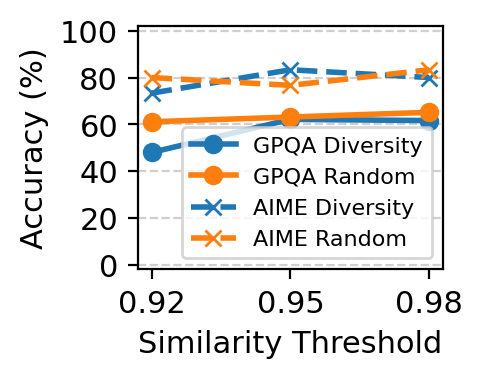

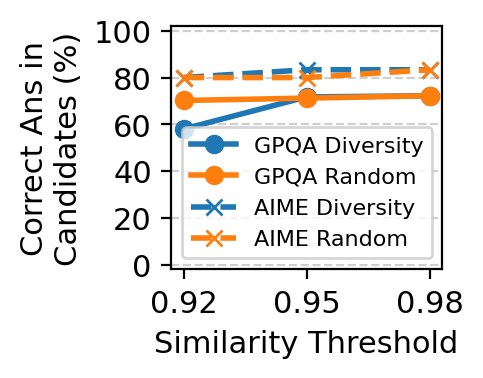

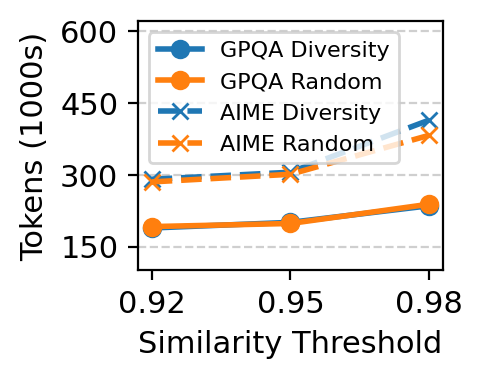

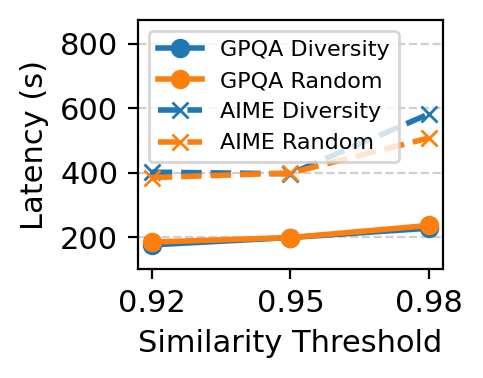

In [80]:
# Cell 5:
can_plot_gpqa = df_gpqa_experiments is not None and not df_gpqa_experiments.empty and \
                all(col in df_gpqa_experiments.columns for col in ['strategy', 'threshold'])
can_plot_aime = df_aime_experiments is not None and not df_aime_experiments.empty and \
                all(col in df_aime_experiments.columns for col in ['strategy', 'threshold'])

if not can_plot_gpqa and not can_plot_aime:
    print("Neither GPQA nor AIME experiment data is available or valid for plotting.")
else:
    if not can_plot_gpqa:
        print("Warning: GPQA experiment data is missing or invalid. Plots will only show AIME data if available.")
    if not can_plot_aime:
        print("Warning: AIME experiment data is missing or invalid. Plots will only show GPQA data if available.")

    # Plot 1: Accuracy
    plot_comparison(
        df_gpqa_experiments if can_plot_gpqa else None,
        df_aime_experiments if can_plot_aime else None,
        gpqa_baseline_metrics_data, # Pass GPQA baselines
        aime_baseline_metrics_data,  # Pass AIME baselines
        'accuracy',
        'Accuracy (%)', # Updated label
    )

    # Plot 2: % Correct Answer in Candidates
    plot_comparison(
        df_gpqa_experiments if can_plot_gpqa else None,
        df_aime_experiments if can_plot_aime else None,
        gpqa_baseline_metrics_data,
        aime_baseline_metrics_data,
        'pct_correct_in_candidates',
        'Correct Ans in\nCandidates (%)', # Updated label
    )

    # Plot 3: Mean Completion Tokens per Question
    plot_comparison(
        df_gpqa_experiments if can_plot_gpqa else None,
        df_aime_experiments if can_plot_aime else None,
        gpqa_baseline_metrics_data,
        aime_baseline_metrics_data,
        'mean_completion_tokens',
        'Tokens (1000s)',
        lower_is_better=True
    )

    # Plot 4: Mean Processing Time per Question
    plot_comparison(
        df_gpqa_experiments if can_plot_gpqa else None,
        df_aime_experiments if can_plot_aime else None,
        gpqa_baseline_metrics_data,
        aime_baseline_metrics_data,
        'mean_processing_time',
        'Latency (s)',
        lower_is_better=True
    )

--- Loading GPQA Experiments ---

--- GPQA Pruning Experiments Data ---
                             folder   accuracy  pct_correct_in_candidates  mean_completion_tokens  mean_processing_time   strategy  threshold
0  diversity_n64_thresh0.92_delay20  48.000000                  58.000000              188.707720            176.094023  diversity       0.92
3     random_n64_thresh0.92_delay20  61.111111                  70.202020              191.623313            184.958314     random       0.92
1  diversity_n64_thresh0.95_delay20  62.121212                  71.717172              200.499101            199.059972  diversity       0.95
4     random_n64_thresh0.95_delay20  63.131313                  71.212121              198.144621            198.818318     random       0.95
2  diversity_n64_thresh0.98_delay20  61.616162                  72.222222              235.143838            227.986663  diversity       0.98
5     random_n64_thresh0.98_delay20  65.151515                  72.222222   

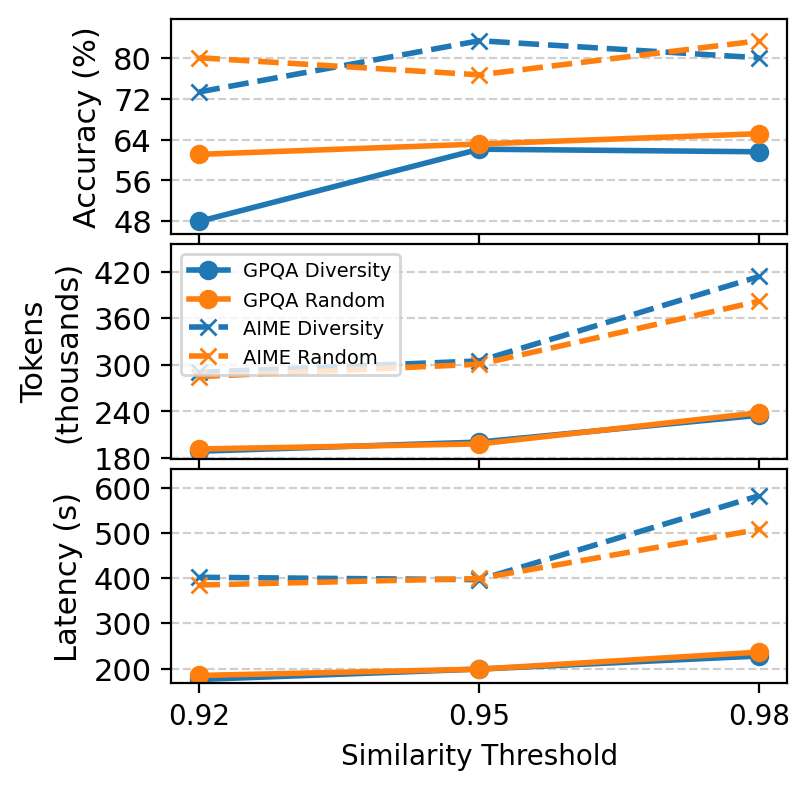

In [97]:
# Cell 1: (No change)
import pandas as pd
import json
import os
import ast # For safely evaluating string representations of lists
import matplotlib.pyplot as plt
import numpy as np
import re # For extracting threshold from folder name
from pathlib import Path
import matplotlib.ticker as mticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # Use tab10 color palette

# --- Configuration ---
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path("/home/users/ntu/{user}/slimsc/prune/results".format(user=user))
GPQA_BASE_PATH = Path(f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/gpqa_diamond/")
AIME_BASE_PATH = Path(f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/aime/")

# Define the experiment sets (assumed to be the same for GPQA and AIME)
EXPERIMENT_SUBFOLDERS = [
    "diversity_n64_thresh0.92_delay20",
    "diversity_n64_thresh0.95_delay20",
    "diversity_n64_thresh0.98_delay20",
    "random_n64_thresh0.92_delay20",
    "random_n64_thresh0.95_delay20",
    "random_n64_thresh0.98_delay20",
]

# Baselines subfolders, expected to exist under both GPQA_BASE_PATH and AIME_BASE_PATH
BASELINE_SUBFOLDERS = [
    "sc_1_control",
    "sc_64_control"
]

# For parsing strategy and threshold
def parse_experiment_name(folder_name):
    strategy_match = re.search(r"^(diversity|random)_", folder_name)
    threshold_match = re.search(r"thresh(\d+\.\d+)", folder_name)

    strategy = strategy_match.group(1) if strategy_match else None
    threshold = float(threshold_match.group(1)) if threshold_match else None

    return strategy, threshold

# Function to check if correct answer is in candidates
def check_correct_in_candidates(row):
    try:
        # Ensure 'individual_answers_str' exists and is a string
        if 'individual_answers_str' not in row or not isinstance(row['individual_answers_str'], str):
            return False
        # Ensure 'correct_answer' is not NaN or None before converting to string
        if pd.isna(row['correct_answer']):
            return False

        candidates = ast.literal_eval(row['individual_answers_str'])
        # MODIFICATION: Convert correct_answer to string for comparison
        return str(row['correct_answer']) in candidates
    except (ValueError, SyntaxError, KeyError, TypeError): # Handle malformed strings, empty lists, missing keys, or non-list types
        return False

# Cell 2: (No change, already handles parsing and conversion)
def load_experiment_metrics(base_path, exp_subfolder):
    """
    Loads metrics from a single experiment's evaluation_summary.csv and aggregated_metrics.json.
    Converts accuracy and pct_correct_in_candidates to percentages (0-100).
    Ensures other numeric metrics are converted to float.
    """
    full_path = os.path.join(base_path, exp_subfolder)
    eval_summary_path = os.path.join(full_path, "evaluation_summary.csv")
    agg_metrics_path = os.path.join(full_path, "aggregated_metrics.json")

    metrics = {
        "folder": exp_subfolder,
        "accuracy": None,
        "pct_correct_in_candidates": None,
        "mean_completion_tokens": None,
        "mean_processing_time": None,
        "strategy": None,
        "threshold": None
    }

    def to_float_or_none(val, field_name_for_warning="value"):
        if val is None:
            return None
        try:
            if isinstance(val, str):
                 # Remove non-numeric, non-decimal, non-sign characters, but be careful with percentages
                 cleaned_val_str = re.sub(r'[^\d.-]', '', val)
                 # Basic check to prevent converting things like 'N/A' to float('') -> 0
                 if not cleaned_val_str or cleaned_val_str in ['.', '-', '+']:
                     return None
                 return float(cleaned_val_str)
            # Handle boolean specifically if needed, though not expected for these metrics
            if isinstance(val, bool):
                return float(val)
            return float(val)
        except (ValueError, TypeError):
            # print(f"Warning: Could not convert {field_name_for_warning} '{val}' from {exp_subfolder} (path: {base_path}) to float. Setting to None.")
            return None # Return None instead of printing for every single failure

    if os.path.exists(eval_summary_path):
        try:
            df_eval = pd.read_csv(eval_summary_path)
            if not df_eval.empty and 'final_score' in df_eval.columns:
                df_eval['final_score'] = pd.to_numeric(df_eval['final_score'], errors='coerce')
                accuracy_val = df_eval['final_score'].mean() # Mean is NaN if all are NaN after coerce
                if pd.notna(accuracy_val):
                    metrics["accuracy"] = accuracy_val * 100 # Convert to percentage

                if 'individual_answers_str' in df_eval.columns and 'correct_answer' in df_eval.columns:
                     # Ensure these columns are treated as strings to prevent apply errors
                    df_eval['individual_answers_str'] = df_eval['individual_answers_str'].astype(str)
                    df_eval['correct_answer'] = df_eval['correct_answer'].astype(str) # Treat correct answer as string for comparison

                    df_eval['correct_in_candidates'] = df_eval.apply(check_correct_in_candidates, axis=1)
                    pct_val = df_eval['correct_in_candidates'].mean() # Mean is NaN if all are NaN
                    if pd.notna(pct_val):
                         metrics["pct_correct_in_candidates"] = pct_val * 100 # Convert to percentage
                else:
                    print(f"Warning: 'individual_answers_str' or 'correct_answer' column missing in {eval_summary_path} or data is empty. Cannot calculate pct_correct_in_candidates for {exp_subfolder}.")

            elif df_eval.empty:
                print(f"Warning: {eval_summary_path} is empty for {exp_subfolder}.")
            else:
                print(f"Warning: 'final_score' column missing in {eval_summary_path} for {exp_subfolder}.")
        except Exception as e:
            print(f"Error reading or processing {eval_summary_path} for {exp_subfolder}: {e}")
    # else:
        # print(f"Warning: {eval_summary_path} not found for {exp_subfolder}.") # Suppress "not found" for expected files

    if os.path.exists(agg_metrics_path):
        try:
            with open(agg_metrics_path, 'r') as f:
                agg_data = json.load(f)
            json_metrics_dict = agg_data.get("metrics", {})

            mean_tokens_val = to_float_or_none(
                json_metrics_dict.get("mean_total_completion_tokens_per_question"),
                "mean_total_completion_tokens_per_question"
            )
            if mean_tokens_val is not None:
                 metrics["mean_completion_tokens"] = mean_tokens_val / 1000 # Convert to thousands

            metrics["mean_processing_time"] = to_float_or_none(
                json_metrics_dict.get("mean_processing_duration_sec_per_question"),
                "mean_processing_duration_sec_per_question"
            )
        except Exception as e:
            print(f"Error reading or processing {agg_metrics_path} for {exp_subfolder}: {e}")
    # else:
        # print(f"Warning: {agg_metrics_path} not found for {exp_subfolder}.") # Suppress "not found" for expected files

    # Handle strategy and threshold parsing for experiment vs baseline folders
    if exp_subfolder in EXPERIMENT_SUBFOLDERS:
        strategy, threshold_val = parse_experiment_name(exp_subfolder)
        metrics["strategy"] = strategy
        metrics["threshold"] = to_float_or_none(threshold_val, "threshold")
    elif exp_subfolder in BASELINE_SUBFOLDERS:
         # For baselines, use the folder name as the 'strategy' or identifier
        metrics["strategy"] = exp_subfolder
        metrics["threshold"] = None # Baselines don't have a threshold

    return metrics


# Cell 3: (No change - data loading)
# --- Load GPQA Pruning Experiments Data ---
gpqa_metrics_data = []
print("--- Loading GPQA Experiments ---")
for subfolder in EXPERIMENT_SUBFOLDERS:
    metrics = load_experiment_metrics(GPQA_BASE_PATH, subfolder)
    # Only add if parsing was successful and it's not treated as a baseline
    if metrics["strategy"] in ["diversity", "random"] and metrics["threshold"] is not None:
         gpqa_metrics_data.append(metrics)
    # else:
        # print(f"Skipping GPQA experiment data for {subfolder} (not diversity/random strategy or missing threshold).")


df_gpqa_experiments = pd.DataFrame(gpqa_metrics_data)
if not df_gpqa_experiments.empty:
    for col in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time', 'threshold']:
        if col in df_gpqa_experiments.columns:
            df_gpqa_experiments[col] = pd.to_numeric(df_gpqa_experiments[col], errors='coerce')
    # Ensure threshold is sorted for plotting
    df_gpqa_experiments = df_gpqa_experiments.sort_values(by='threshold')


print("\n--- GPQA Pruning Experiments Data ---")
if not df_gpqa_experiments.empty:
    print(df_gpqa_experiments.to_string())
else:
    print("No GPQA pruning experiment data loaded.")

# --- Load AIME Pruning Experiments Data ---
aime_metrics_data = []
print("\n--- Loading AIME Experiments ---")
for subfolder in EXPERIMENT_SUBFOLDERS:
    metrics = load_experiment_metrics(AIME_BASE_PATH, subfolder)
    # Only add if parsing was successful and it's not treated as a baseline
    if metrics["strategy"] in ["diversity", "random"] and metrics["threshold"] is not None:
        aime_metrics_data.append(metrics)
    # else:
        # print(f"Skipping AIME experiment data for {subfolder} (not diversity/random strategy or missing threshold).")


df_aime_experiments = pd.DataFrame(aime_metrics_data)
if not df_aime_experiments.empty:
    for col in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time', 'threshold']:
        if col in df_aime_experiments.columns:
            df_aime_experiments[col] = pd.to_numeric(df_aime_experiments[col], errors='coerce')
     # Ensure threshold is sorted for plotting
    df_aime_experiments = df_aime_experiments.sort_values(by='threshold')

print("\n--- AIME Pruning Experiments Data ---")
if not df_aime_experiments.empty:
    print(df_aime_experiments.to_string())
else:
    print("\nNo AIME pruning experiment data loaded.")

# --- Load GPQA Baseline Data ---
# We still load baseline data, but won't plot the horizontal lines
gpqa_baseline_metrics_data = {}
print("\n--- Loading GPQA Baselines ---")
for subfolder in BASELINE_SUBFOLDERS:
    metrics = load_experiment_metrics(GPQA_BASE_PATH, subfolder)
    # Check if metrics were successfully loaded for this baseline
    if metrics and any(pd.notna(metrics[key]) for key in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time']):
         gpqa_baseline_metrics_data[subfolder] = metrics
         # print(f"Loaded GPQA Baseline {subfolder}: Acc {metrics.get('accuracy')}")
    else:
         print(f"Warning: Could not load valid metrics for GPQA baseline {subfolder}.")


print("\n--- GPQA Baseline Data ---")
if gpqa_baseline_metrics_data:
    for name, data in gpqa_baseline_metrics_data.items():
        print(f"{name}:")
        if data:
            acc = data.get('accuracy'); pct_cand = data.get('pct_correct_in_candidates')
            tokens = data.get('mean_completion_tokens'); time = data.get('mean_processing_time')
            print(f"  Accuracy: {acc:.2f}%" if pd.notna(acc) else "N/A")
            print(f"  % Correct in Candidates: {pct_cand:.2f}%" if pd.notna(pct_cand) else "N/A")
            print(f"  Mean Completion Tokens: {float(tokens):.2f}k" if pd.notna(tokens) else "N/A")
            print(f"  Mean Processing Time: {float(time):.2f}s" if pd.notna(time) else "N/A")
        else:
            print("  Data not loaded.")
else:
    print("No GPQA baseline data loaded.")


# --- Load AIME Baseline Data ---
# We still load baseline data, but won't plot the horizontal lines
aime_baseline_metrics_data = {}
print("\n--- Loading AIME Baselines ---")
for subfolder in BASELINE_SUBFOLDERS:
    metrics = load_experiment_metrics(AIME_BASE_PATH, subfolder)
     # Check if metrics were successfully loaded for this baseline
    if metrics and any(pd.notna(metrics[key]) for key in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time']):
        aime_baseline_metrics_data[subfolder] = metrics
        # print(f"Loaded AIME Baseline {subfolder}: Acc {metrics.get('accuracy')}")
    else:
        print(f"Warning: Could not load valid metrics for AIME baseline {subfolder}.")


print("\n--- AIME Baseline Data ---")
if aime_baseline_metrics_data:
    for name, data in aime_baseline_metrics_data.items():
        print(f"{name}:")
        if data:
            acc = data.get('accuracy'); pct_cand = data.get('pct_correct_in_candidates')
            tokens = data.get('mean_completion_tokens'); time = data.get('mean_processing_time')
            print(f"  Accuracy: {acc:.2f}%" if pd.notna(acc) else "N/A")
            print(f"  % Correct in Candidates: {pct_cand:.2f}%" if pd.notna(pct_cand) else "N/A")
            print(f"  Mean Completion Tokens: {float(tokens):.2f}k" if pd.notna(tokens) else "N/A")
            print(f"  Mean Processing Time: {float(time):.2f}s" if pd.notna(time) else "N/A")
        else:
            print("  Data not loaded.")
else:
    print("No AIME baseline data loaded.")


# Cell 4: (No change from previous step - baselines already removed)
# import matplotlib.ticker as mticker # Already imported in Cell 1

def plot_metric_on_axis(ax, df_gpqa_exp, df_aime_exp,
                        metric_key, y_label): # Removed baseline data args
    """
    Generates line graphs for a specific metric on a given axis, comparing GPQA and AIME strategies.
    AIME lines use the same color as GPQA but different texture (linestyle).
    Does NOT create a new figure or legend. Returns handles and labels for a common legend.
    """

    strategy_colors = {
        'diversity': plt.cm.tab10.colors[0],
        'random': plt.cm.tab10.colors[1]
    }
    gpqa_linestyle = '-'
    gpqa_marker = 'o'
    aime_linestyle = '--'
    aime_marker = 'x'

    all_y_values_for_ylim = []

    # Collect all unique thresholds from available dataframes
    all_thresholds_set = set()
    if df_gpqa_exp is not None and not df_gpqa_exp.empty and 'threshold' in df_gpqa_exp.columns:
        all_thresholds_set.update(df_gpqa_exp['threshold'].dropna().unique())
    if df_aime_exp is not None and not df_aime_exp.empty and 'threshold' in df_aime_exp.columns:
        all_thresholds_set.update(df_aime_exp['threshold'].dropna().unique())

    thresholds = sorted(list(all_thresholds_set))

    if not thresholds:
        # Cannot plot lines without thresholds, just set labels and return empty lists
        ax.set_ylabel(y_label, fontsize=11)
        # X-axis label will be set later on the bottom-most plot
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.grid(True, linestyle='--', alpha=0.6, axis='y')
        # Set a dummy x-lim if no thresholds, but only if not sharing x
        # If sharing x, the x-limits will be determined by other axes
        # For now, just return empty handles/labels
        return [], []

    # Determine unique strategies present in data
    unique_strategies = []
    temp_strategies_set = set()
    if df_gpqa_exp is not None and not df_gpqa_exp.empty and 'strategy' in df_gpqa_exp.columns:
        temp_strategies_set.update(df_gpqa_exp['strategy'].dropna().unique())
    if df_aime_exp is not None and not df_aime_exp.empty and 'strategy' in df_aime_exp.columns:
        temp_strategies_set.update(df_aime_exp['strategy'].dropna().unique())
    unique_strategies = sorted(list(temp_strategies_set)) # Ensure consistent order

    # Store handles and labels locally for this axis to pass back
    axis_handles = []
    axis_labels = []

    # Plot Pruning Experiments
    for strategy in unique_strategies:
        color = strategy_colors.get(strategy, 'gray')

        # GPQA Pruning Data
        if df_gpqa_exp is not None and not df_gpqa_exp.empty and strategy in df_gpqa_exp['strategy'].unique() and metric_key in df_gpqa_exp.columns:
            gpqa_strategy_data = df_gpqa_exp[df_gpqa_exp['strategy'] == strategy].set_index('threshold').reindex(thresholds)
            # Use .values.astype(float) and mask NaNs for plotting
            gpqa_values = gpqa_strategy_data[metric_key].values.astype(float)
            valid_indices = np.where(pd.notna(gpqa_values))[0]
            if valid_indices.size > 0:
                line, = ax.plot(np.array(thresholds)[valid_indices], gpqa_values[valid_indices],
                                label=f'GPQA {strategy.capitalize()}', color=color,
                                linestyle=gpqa_linestyle, marker=gpqa_marker, linewidth=2)
                axis_handles.append(line)
                axis_labels.append(f'GPQA {strategy.capitalize()}')
                all_y_values_for_ylim.extend(gpqa_values[valid_indices])


        # AIME Pruning Data
        if df_aime_exp is not None and not df_aime_exp.empty and strategy in df_aime_exp['strategy'].unique() and metric_key in df_aime_exp.columns:
            aime_strategy_data = df_aime_exp[df_aime_exp['strategy'] == strategy].set_index('threshold').reindex(thresholds)
            # Use .values.astype(float) and mask NaNs for plotting
            aime_values = aime_strategy_data[metric_key].values.astype(float)
            valid_indices = np.where(pd.notna(aime_values))[0]
            if valid_indices.size > 0:
                line, = ax.plot(np.array(thresholds)[valid_indices], aime_values[valid_indices],
                                label=f'AIME {strategy.capitalize()}', color=color,
                                linestyle=aime_linestyle, marker=aime_marker, linewidth=2)
                axis_handles.append(line)
                axis_labels.append(f'AIME {strategy.capitalize()}')
                all_y_values_for_ylim.extend(aime_values[valid_indices])


    # --- Baselines are NOT plotted as horizontal lines ---


    # --- Y-axis limits and formatting ---
    valid_y_values = [v for v in all_y_values_for_ylim if pd.notna(v)]

    if metric_key in ['accuracy', 'pct_correct_in_candidates']:
         # Find min/max values from plotted data
        min_val = min(valid_y_values) if valid_y_values else 0
        max_val = max(valid_y_values) if valid_y_values else 100

        # Set limits with some margin
        y_min = max(0, min_val * 0.95) if min_val > 0.1 else max(0, min_val - 5)
        y_max = min(100, max_val * 1.05) if max_val < 100 else min(100, max_val + 5)

        # Ensure min is not greater than max, and provide a default range if no data
        if y_min >= y_max:
             y_min = 0
             y_max = 100 if not valid_y_values else y_min + 10 # Give a small range if data exists but min>=max

        ax.set_ylim(bottom=y_min, top=y_max)
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, integer=True, prune='both'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d')) # Format as integer percentage
    else: # Cost metrics (Tokens, Latency)
        min_val = min(valid_y_values) if valid_y_values else 0
        max_val = max(valid_y_values) if valid_y_values else 10 # Default max for cost

        # Set limits with some margin, ensuring bottom is 0 or slightly below min
        y_min = max(0, min_val * 0.95) if min_val > 0.1 else 0
        y_max = max_val * 1.1 if max_val > 0 else 10 # 10% margin or default

        # Ensure min is not greater than max, and provide a default range if no data
        if y_min >= y_max:
             y_min = 0
             y_max = 10 if not valid_y_values else y_min + 1 # Give a small range

        ax.set_ylim(bottom=y_min, top=y_max)

        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
        plt.ticklabel_format(style='plain', axis='y', useOffset=False)


    # --- Labels and Ticks ---
    # X-label is handled by the shared axis on the bottom plot
    ax.set_ylabel(y_label, fontsize=11)

    # Set X-ticks on this axis (they will appear on the shared axis)
    if thresholds:
        ax.set_xticks(thresholds)
        # The xticklabels will be set on the bottom-most axis only
    else:
         ax.set_xticks([]) # No ticks if no threshold data


    ax.tick_params(axis='both', which='major', labelsize=11)

    # Hide x-axis tick labels on upper plots (Logic moved to Cell 5)


    ax.grid(True, linestyle='--', alpha=0.6, axis='y')

    # Return handles and labels generated by this axis
    return axis_handles, axis_labels


# Cell 5: (Modified orchestration cell - legend placed in bottom axis)
# Define the list of metrics and their corresponding y-labels
metrics_to_plot = [
    ('accuracy', 'Accuracy (%)'),
    # ('pct_correct_in_candidates', 'Correct Ans in\nCandidates (%)'),
    ('mean_completion_tokens', 'Tokens\n(thousands)'),
    ('mean_processing_time', 'Latency (s)')
]

# Check if experiment data is available for plotting
can_plot_exp = (df_gpqa_experiments is not None and not df_gpqa_experiments.empty and all(col in df_gpqa_experiments.columns for col in ['strategy', 'threshold'])) or \
               (df_aime_experiments is not None and not df_aime_experiments.empty and all(col in df_aime_experiments.columns for col in ['strategy', 'threshold']))

if not can_plot_exp:
     print("Neither GPQA nor AIME experiment data is available or valid for plotting. No lines will be plotted.")


# Create the figure and a set of subplots sharing the x-axis
# Adjust figsize for a smaller overall plot while allowing vertical space
# Reduced height slightly as legend is now inside a subplot
fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=1,
                         figsize=(4, 4), # Adjusted size
                         sharex=True, squeeze=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Dictionary to collect unique handles and labels for the common legend
legend_dict = {}

# Loop through metrics and axes to plot on each subplot
for i, (metric_key, y_label) in enumerate(metrics_to_plot):
    ax = axes[i] # Get the current axis

    # Plot the metric on the current axis using the refactored function
    handles, labels = plot_metric_on_axis(
        ax,
        df_gpqa_experiments if can_plot_exp else None,
        df_aime_experiments if can_plot_exp else None,
        metric_key,
        y_label
    )

    # Collect unique handles and labels
    for handle, label in zip(handles, labels):
        legend_dict[label] = handle

    # Hide x-axis tick labels on all but the bottom plot
    if i < len(metrics_to_plot) - 1:
        plt.setp(ax.get_xticklabels(), visible=False)


# --- Configure the shared X-axis (on the bottom-most plot) ---
bottom_ax = axes[-1] # The last axis in the array is the bottom one
bottom_ax.set_xlabel('Similarity Threshold', fontsize=10)

# Set the x-tick labels on the bottom axis
all_thresholds_set = set()
if df_gpqa_experiments is not None and not df_gpqa_experiments.empty and 'threshold' in df_gpqa_experiments.columns:
    all_thresholds_set.update(df_gpqa_experiments['threshold'].dropna().unique())
if df_aime_experiments is not None and not df_aime_experiments.empty and 'threshold' in df_aime_experiments.columns:
    all_thresholds_set.update(df_aime_experiments['threshold'].dropna().unique())
thresholds = sorted(list(all_thresholds_set))

if thresholds:
     bottom_ax.set_xticks(thresholds)
     bottom_ax.set_xticklabels([f"{t:.2f}" for t in thresholds], fontsize=10)
     # Set a slight margin on the x-axis
     if len(thresholds) > 1:
          x_margin = (max(thresholds) - min(thresholds)) * 0.05
     else: # Handle case with only one threshold
          x_margin = 0.01 # Small default margin
     bottom_ax.set_xlim(min(thresholds) - x_margin, max(thresholds) + x_margin)
else:
     bottom_ax.set_xticks([]) # No ticks if no threshold data


# --- Create a single common legend inside the bottom-most subplot ---
# Define the desired order of labels for the legend (only experiment strategies)
desired_label_order = [
    "GPQA Diversity",
    "GPQA Random",
    "AIME Diversity",
    "AIME Random",
]

# Build the ordered lists of handles and labels based on the dictionary
ordered_handles = []
ordered_labels = []

# Add items in the desired order
for label in desired_label_order:
    if label in legend_dict:
        ordered_handles.append(legend_dict[label])
        ordered_labels.append(label)

legend_ax = axes[1]
# Create the legend on the bottom axis
if ordered_handles: # Only create legend if there are items
    legend_ax.legend(ordered_handles, ordered_labels,
                     loc='upper left', # Position inside the bottom axis
                     ncol=1, # Using 1 column might fit better in a small subplot
                     fontsize=7,
                     frameon=True
                    )
    # Note: Using ncol=1 usually makes it taller, which might be better for fitting in the 'upper left' of the Latency plot. You can change to ncol=2 if you prefer a wider, shorter legend, but it might overlap data points.

# Adjust layout
plt.subplots_adjust(
    left=0.18,   # Adjusted left margin for y-labels
    right=0.95,  # Adjust right margin
    top=0.95,    # Reduced top margin since legend is internal
    bottom=0.12, # Adjust bottom margin for x-label and ticks
    hspace=0.05  # Reduce vertical space between subplots
)


# Display the combined figure
plt.show()


--- Plotting Combined Threshold and Delay vs. Accuracy ---


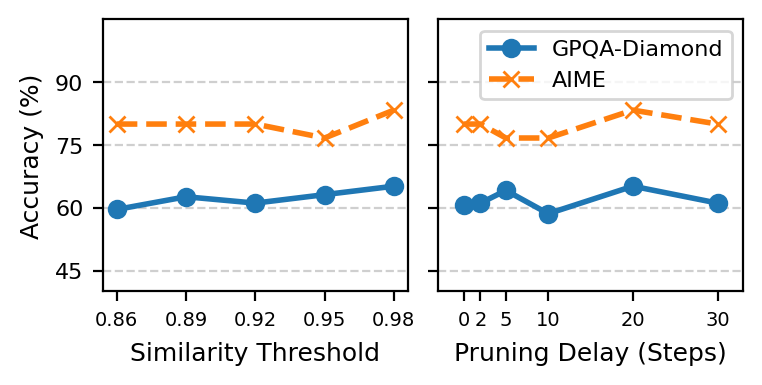

In [135]:
def plot_threshold_on_axis(ax, df_gpqa, df_aime):
    """
    Plots similarity threshold vs. accuracy for GPQA and AIME on a given axis.
    Returns handles and labels for the legend.
    """
    gpqa_color = plt.cm.tab10.colors[0]  # Blue
    aime_color = plt.cm.tab10.colors[1]   # Orange
    handles = []
    labels = []

    # Plot GPQA data
    if df_gpqa is not None and not df_gpqa.empty and 'threshold' in df_gpqa.columns and 'accuracy' in df_gpqa.columns:
        line_gpqa, = ax.plot(df_gpqa['threshold'], df_gpqa['accuracy'],
                               label='GPQA-Diamond', color=gpqa_color, marker='o', linestyle='-', linewidth=2)
        handles.append(line_gpqa)
        labels.append('GPQA-Diamond')
    else:
        print("Warning: GPQA threshold data is missing or invalid for plotting on axis.")

    # Plot AIME data
    if df_aime is not None and not df_aime.empty and 'threshold' in df_aime.columns and 'accuracy' in df_aime.columns:
        line_aime, = ax.plot(df_aime['threshold'], df_aime['accuracy'],
                               label='AIME', color=aime_color, marker='x', linestyle='--', linewidth=2)
        handles.append(line_aime)
        labels.append('AIME')
    else:
        print("Warning: AIME threshold data is missing or invalid for plotting on axis.")

    # --- X-axis (Threshold) ---
    x_ticks_data = []
    if df_gpqa is not None and not df_gpqa.empty and 'threshold' in df_gpqa.columns:
        x_ticks_data.extend(df_gpqa['threshold'].unique())
    if df_aime is not None and not df_aime.empty and 'threshold' in df_aime.columns:
        x_ticks_data.extend(df_aime['threshold'].unique())

    if x_ticks_data:
        unique_sorted_x_ticks = sorted(list(set(x_ticks_data)))
        ax.set_xticks(unique_sorted_x_ticks)
        ax.set_xticklabels([f"{t:.2f}" for t in unique_sorted_x_ticks], fontsize=7) # Smaller fontsize
        # Add small x-margin
        if len(unique_sorted_x_ticks) > 1:
            x_margin = (max(unique_sorted_x_ticks) - min(unique_sorted_x_ticks)) * 0.05
            ax.set_xlim(min(unique_sorted_x_ticks) - x_margin, max(unique_sorted_x_ticks) + x_margin)
        elif unique_sorted_x_ticks:
             ax.set_xlim(unique_sorted_x_ticks[0] - 0.01, unique_sorted_x_ticks[0] + 0.01)


    ax.set_xlabel('Similarity Threshold', fontsize=9) # Smaller fontsize
    ax.tick_params(axis='y', which='major', labelsize=8) # Y-ticks only on left plot if sharey
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    return handles, labels

# --- Refactored Plotting Function for Delay vs. Accuracy on a given Axis ---
def plot_delay_on_axis(ax, df_gpqa, df_aime):
    """
    Plots pruning delay vs. accuracy for GPQA and AIME on a given axis.
    Returns handles and labels for the legend.
    """
    gpqa_color = plt.cm.tab10.colors[0]  # Blue
    aime_color = plt.cm.tab10.colors[1]   # Orange
    handles = []
    labels = []

    # Plot GPQA data
    if df_gpqa is not None and not df_gpqa.empty and 'delay' in df_gpqa.columns and 'accuracy' in df_gpqa.columns:
        line_gpqa, = ax.plot(df_gpqa['delay'], df_gpqa['accuracy'],
                               label='GPQA-Diamond', color=gpqa_color, marker='o', linestyle='-', linewidth=2)
        handles.append(line_gpqa)
        labels.append('GPQA-Diamond')
    else:
        print("Warning: GPQA delay data is missing or invalid for plotting on axis.")

    # Plot AIME data
    if df_aime is not None and not df_aime.empty and 'delay' in df_aime.columns and 'accuracy' in df_aime.columns:
        line_aime, = ax.plot(df_aime['delay'], df_aime['accuracy'],
                               label='AIME', color=aime_color, marker='x', linestyle='--', linewidth=2)
        handles.append(line_aime)
        labels.append('AIME')
    else:
        print("Warning: AIME delay data is missing or invalid for plotting on axis.")

    # --- X-axis (Delay) ---
    x_ticks_data = []
    if df_gpqa is not None and not df_gpqa.empty and 'delay' in df_gpqa.columns:
        x_ticks_data.extend(df_gpqa['delay'].unique())
    if df_aime is not None and not df_aime.empty and 'delay' in df_aime.columns:
        x_ticks_data.extend(df_aime['delay'].unique())

    if x_ticks_data:
        unique_sorted_x_ticks = sorted(list(set(x_ticks_data)))
        ax.set_xticks(unique_sorted_x_ticks)
        ax.set_xticklabels([str(int(d)) for d in unique_sorted_x_ticks], fontsize=7) # Smaller fontsize
        # Add small x-margin
        if len(unique_sorted_x_ticks) > 1:
            x_margin = (max(unique_sorted_x_ticks) - min(unique_sorted_x_ticks)) * 0.1 # larger margin for discrete steps
            ax.set_xlim(min(unique_sorted_x_ticks) - x_margin, max(unique_sorted_x_ticks) + x_margin)
        elif unique_sorted_x_ticks:
             ax.set_xlim(unique_sorted_x_ticks[0] - 1, unique_sorted_x_ticks[0] + 1)


    ax.set_xlabel('Pruning Delay (Steps)', fontsize=9) # Smaller fontsize
    # ax.tick_params(axis='y', which='major', labelsize=7) # Y-ticks will be hidden by sharey
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    return handles, labels

# --- Orchestration for Combined Plot ---
print("\n--- Plotting Combined Threshold and Delay vs. Accuracy ---")

# Create figure with two subplots sharing the y-axis
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(4, 2), sharey=True)

# --- Plot Threshold vs. Accuracy on the left subplot ---
handles_thresh, labels_thresh = plot_threshold_on_axis(ax_left, df_gpqa_threshold, df_aime_threshold)

# --- Plot Delay vs. Accuracy on the right subplot ---
handles_delay, labels_delay = plot_delay_on_axis(ax_right, df_gpqa_delay, df_aime_delay)

# --- Set common Y-axis properties ---
ax_left.set_ylabel('Accuracy (%)', fontsize=9) # Smaller fontsize
# Define a common y-axis range for both plots
common_y_min = 40
common_y_max = 105
ax_left.set_ylim(bottom=common_y_min, top=common_y_max)
ax_left.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, integer=True, prune='both')) # Adjusted nbins

# --- Create a common legend ---
# Consolidate unique handles and labels
# The labels "GPQA-Diamond" and "AIME" should be consistent, so we can take from either.
# Prefer taking from handles_thresh if available, assuming lines are plotted.
legend_handles = []
legend_labels = []

# Create a dictionary to ensure unique labels
unique_legend_items = {}
for h, l in zip(handles_thresh + handles_delay, labels_thresh + labels_delay):
    if l not in unique_legend_items:
        unique_legend_items[l] = h

# Maintain a specific order if desired (e.g., GPQA first, then AIME)
desired_order = ['GPQA-Diamond', 'AIME']
for label in desired_order:
    if label in unique_legend_items:
        legend_labels.append(label)
        legend_handles.append(unique_legend_items[label])

if legend_handles:
    # Place legend on the right plot (ax_right) for better fit
    ax_right.legend(legend_handles, legend_labels, loc='upper right', fontsize=8, frameon=True) # Boxed legend, smaller fontsize

# Adjust layout to prevent overlap and fit everything
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.22, top=0.9, wspace=0.1) # Fine-tune spacing

plt.show()

In [129]:
# --- Plotting Function for Threshold ---
# Modified to accept an axis object and return handles/labels
def plot_threshold_vs_accuracy(ax, df_gpqa, df_aime): # Added ax argument
    """
    Plots similarity threshold vs. accuracy for GPQA and AIME onto a given axis.
    GPQA in blue, AIME in orange. Accuracy as percentage. No title.
    Returns legend handles and labels.
    """
    # Remove fig, ax = plt.subplots(...)

    gpqa_color = plt.cm.tab10.colors[0]  # Blue
    aime_color = plt.cm.tab10.colors[1]   # Orange

    # all_y_values_for_ylim = [] # Not needed here

    axis_handles = []
    axis_labels = []

    # Plot GPQA data
    if df_gpqa is not None and not df_gpqa.empty and 'threshold' in df_gpqa.columns and 'accuracy' in df_gpqa.columns:
        line, = ax.plot(df_gpqa['threshold'], df_gpqa['accuracy'],
                label='GPQA-Diamond', color=gpqa_color, marker='o', linestyle='-', linewidth=2)
        axis_handles.append(line)
        axis_labels.append('GPQA-Diamond')
        # all_y_values_for_ylim.extend(df_gpqa['accuracy'].dropna())


    # Plot AIME data
    if df_aime is not None and not df_aime.empty and 'threshold' in df_aime.columns and 'accuracy' in df_aime.columns:
        line, = ax.plot(df_aime['threshold'], df_aime['accuracy'],
                label='AIME', color=aime_color, marker='x', linestyle='--', linewidth=2)
        axis_handles.append(line)
        axis_labels.append('AIME')
        # all_y_values_for_ylim.extend(df_aime['accuracy'].dropna())


    # --- Y-axis (Accuracy %) ---
    # Keep the y-limits, they will apply to this axis, and sharey ensures consistency
    # ax.set_ylim(bottom=45, top=95) # Adjust limits dynamically later based on ALL data
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, integer=True, prune='both'))
     # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d%%')) # Formatter is set once on the left axis

    # --- X-axis (Threshold) ---
    x_ticks = []
    if df_gpqa is not None and not df_gpqa.empty and 'threshold' in df_gpqa.columns:
        x_ticks.extend(df_gpqa['threshold'].unique())
    if df_aime is not None and not df_aime.empty and 'threshold' in df_aime.columns:
        x_ticks.extend(df_aime['threshold'].unique())

    if x_ticks:
        unique_sorted_x_ticks = sorted(list(set(x_ticks)))
        ax.set_xticks(unique_sorted_x_ticks)
        ax.set_xticklabels([f"{t:.2f}" for t in unique_sorted_x_ticks]) # Format as float with 2 decimal places
        # Add a slight margin to the x-axis
        if len(unique_sorted_x_ticks) > 1:
             x_margin = (max(unique_sorted_x_ticks) - min(unique_sorted_x_ticks)) * 0.05
        else:
             x_margin = 0.01 # Default margin if only one point
        ax.set_xlim(min(unique_sorted_x_ticks) - x_margin, max(unique_sorted_x_ticks) + x_margin)
    else: # Fallback if no data for x-ticks
        ax.set_xticks([])
        ax.set_xlim(0.8, 1.0) # Dummy limits if no data


    # --- Labels and Grid ---
    ax.set_xlabel('Similarity Threshold', fontsize=9)
    # Remove ylabel on this axis, as it will be shared
    # ax.set_ylabel('Accuracy (%)', fontsize=9)
    ax.tick_params(axis='x', which='major', labelsize=8)

    # Remove legend creation
    # if (df_gpqa is not None and not df_gpqa.empty) or \
    #    (df_aime is not None and not df_aime.empty):
    #     ax.legend(loc='best', fontsize=8)

    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    # Remove fig.tight_layout()
    # Remove plt.show()

    return axis_handles, axis_labels # Return handles and labels


# --- Generate the Plot (Remove this block - orchestrated in new cell) ---
# print("\n--- Plotting Threshold vs. Accuracy ---")
# plot_threshold_vs_accuracy(df_gpqa_threshold, df_aime_threshold)


--- Plotting Combined Threshold & Delay vs. Accuracy ---


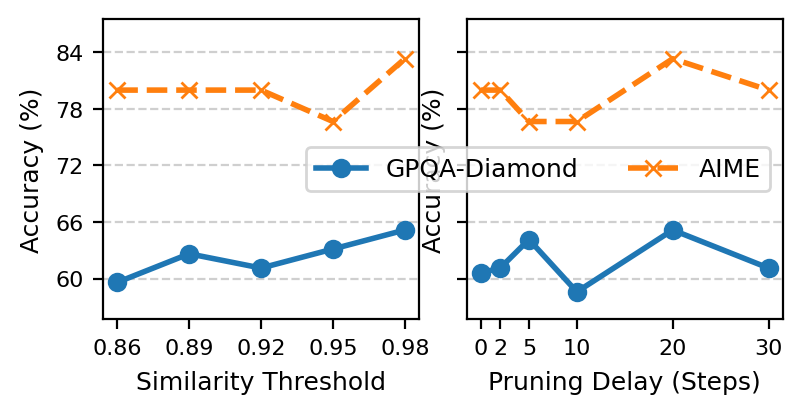

In [131]:
# Cell 6: Combined Plotting - Swapped Axes

# Create a figure with 1 row and 2 columns, sharing the y-axis
# Adjust figsize as needed for two side-by-side plots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(4, 2)) # Example size

# Get the individual axes
ax_threshold = axes[0] # Threshold plot is now on the left
ax_delay = axes[1]     # Delay plot is now on the right

# Dictionary to collect unique handles and labels for the common legend
legend_dict = {}

# --- Plot Threshold vs Accuracy on the LEFT axis (ax_threshold) ---
print("\n--- Plotting Combined Threshold & Delay vs. Accuracy ---")
# Call the threshold plotting function on the LEFT axis
handles_threshold, labels_threshold = plot_threshold_vs_accuracy(ax_threshold, df_gpqa_threshold, df_aime_threshold)

# Collect handles and labels from the threshold plot
for handle, label in zip(handles_threshold, labels_threshold):
    legend_dict[label] = handle

# --- Plot Delay vs Accuracy on the RIGHT axis (ax_delay) ---
# Call the delay plotting function on the RIGHT axis
handles_delay, labels_delay = plot_delay_vs_accuracy(ax_delay, df_gpqa_delay, df_aime_delay)

# Collect handles and labels from the delay plot
for handle, label in zip(handles_delay, labels_delay):
    # This will overwrite if the same label exists (e.g., 'GPQA-Diamond')
    # which is what we want for a common legend
    legend_dict[label] = handle

# --- Configure the shared Y-axis (on the LEFT-most plot, ax_threshold) ---
# The y-axis is shared, so limits and formatter on ax_threshold apply to ax_delay
# Let's set the limits dynamically based on *all* accuracy data
all_accuracy_values = []
if df_gpqa_delay is not None and not df_gpqa_delay.empty and 'accuracy' in df_gpqa_delay.columns:
     all_accuracy_values.extend(df_gpqa_delay['accuracy'].dropna().tolist())
if df_aime_delay is not None and not df_aime_delay.empty and 'accuracy' in df_aime_delay.columns:
     all_accuracy_values.extend(df_aime_delay['accuracy'].dropna().tolist())
if df_gpqa_threshold is not None and not df_gpqa_threshold.empty and 'accuracy' in df_gpqa_threshold.columns:
     all_accuracy_values.extend(df_gpqa_threshold['accuracy'].dropna().tolist())
if df_aime_threshold is not None and not df_aime_threshold.empty and 'accuracy' in df_aime_threshold.columns:
     all_accuracy_values.extend(df_aime_threshold['accuracy'].dropna().tolist())

if all_accuracy_values:
    min_acc = min(all_accuracy_values)
    max_acc = max(all_accuracy_values)
    # Set limits with some margin, bounded by 0 and 100
    y_min = max(0, min_acc * 0.95) if min_acc > 0.1 else max(0, min_acc - 5)
    y_max = min(100, max_acc * 1.05) if max_acc < 99 else min(100, max_acc + 5) # Cap at 100

    # Ensure limits are sensible if only one point or all are same
    if y_min >= y_max:
         y_min = max(0, y_max - 10) # Give a small range if min >= max
         y_max = min(100, y_min + 10)

    # Set limits on the LEFT axis (ax_threshold)
    ax_threshold.set_ylim(bottom=y_min, top=y_max)
    # Set formatter on the LEFT axis (ax_threshold)

else:
     # Default y-limits if no data
     ax_threshold.set_ylim(0, 100)
     print("Warning: No valid accuracy data found for setting shared Y-axis limits.")

ax_threshold.set_ylabel('Accuracy (%)', fontsize=9) # Y-label on the LEFT plot
ax_threshold.tick_params(axis='y', which='major', labelsize=8)

# Remove the y-tick labels from the RIGHT plot (ax_delay) since y-axis is shared
plt.setp(ax_delay.get_yticklabels(), visible=False)


# --- Create a single common boxed legend inside the RIGHT subplot (ax_delay) ---
# Define the desired order of labels for the legend
desired_label_order = [
    "GPQA-Diamond",
    "AIME",
]

# Build the ordered lists of handles and labels based on the dictionary
ordered_handles = []
ordered_labels = []

# Add items in the desired order
for label in desired_label_order:
    if label in legend_dict:
        ordered_handles.append(legend_dict[label])
        ordered_labels.append(label)


# Create the legend on the RIGHT axis (ax_delay)
if ordered_handles: # Only create legend if there are items
    ax_delay.legend(ordered_handles, ordered_labels,
                        loc='best',  # Position inside the right axis
                        ncol=len(ordered_labels), # Set ncol to the number of items for horizontal layout
                        fontsize=9,
                        frameon=True          # Keep the box
                       )

# Adjust layout
# Adjust wspace to control the gap between the two subplots (smaller is good for sharey)
plt.subplots_adjust(
    left=0.1,    # Adjust left margin for the left ylabel
    right=0.95,  # Adjust right margin
    top=0.9,     # Reduced top margin slightly
    bottom=0.15, # Adjust bottom margin for xlabels
    wspace=0.15  # Adjust horizontal space between plots
)

# Display the combined figure
plt.show()